In [1]:
import numpy as np
from matplotlib import pyplot as plt

from qiskit import *
from qiskit.compiler import assemble
from qiskit.pulse.commands.sample_pulse import SamplePulse
from scipy.optimize import curve_fit 
import random
import math
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel

In [2]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_johannesburg')
props, config, defaults = (backend.properties(), backend.configuration(), backend.defaults())

In [3]:
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    # Conversion factors from standard SI units
    us = 1e6
    ns = 1e9
    GHz = 1e-9

    print("Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('u2', qubit),
              properties.gate_length('u2', qubit) * ns,
              properties.frequency(qubit) * GHz))

In [4]:
import numpy as np

dt = config.dt

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qb = 0

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14
describe_qubit(qb, props)

Qubit 0 has a 
  - T1 time of 66.0425002006581 microseconds
  - T2 time of 84.77147856762824 microseconds
  - U2 gate error of 0.00019308121290158328
  - U2 gate duration of 35.555555555555564 nanoseconds
  - resonant frequency of 4.664864310301346 GHz


In [5]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qb)
meas_chan = pulse.MeasureChannel(qb)
acq_chan = pulse.AcquireChannel(qb)

inst_sched_map = defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qb)

In [6]:
Xp = lambda i: pulse.commands.SamplePulse([p for p in defaults.pulse_library
                 if p.name=='Xp_d'+str(i)][0].samples, 'Xp'+str(i))

In [7]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [11]:
pulse_info = [[16, 80, 0.746812671196298],
 [16, 112, 0.7728705049061994],
 [16, 176, 0.6585249221137706],
 [32, 256, 0.3697423251225845],
 [48, 400, 0.22222851740909544],
 [80, 608, 0.13313518634587407],
 [112, 944, 0.09471767851172616],
 [176, 1440, 0.05962263431168813]]

In [20]:
time_max_us = 450
time_step_us = 6
times_us = np.arange(1, time_max_us, time_step_us)

delay_times_dt = times_us * us / config.dt

t1_schedules = []
for i in range(len(pulse_info)):
    for delay in delay_times_dt:
        sched = qiskit.pulse.Schedule(name=f'T1 delay + {delay * config.dt/us} us')
        
        sched += qiskit.pulse.Play(pulse_lib.gaussian(duration=pulse_info[i][1], 
                                                      amp=pulse_info[i][2], 
                                                      sigma=pulse_info[i][0], 
                                                      name=f"Rabi drive amplitude = {pulse_info[i][2]}"), drive_chan)
#         sched += qiskit.pulse.Play(SamplePulse(Xp(qb).samples, name=f'Xp{qb}'), drive_chan)

        sched |= measure << int(delay)
        t1_schedules.append(sched)

num_shots = 512

schedule = pulse.Schedule(name='|0> state')
schedule += measure << schedule.duration
t1_schedules.append(schedule) # add zero state to experiments

schedule = pulse.Schedule(name='|1> state')
schedule += Play(SamplePulse(Xp(qb).samples), drive_chan)
schedule += measure << schedule.duration
t1_schedules.append(schedule) # add 1 state to experiments

In [21]:
t1_experiment = assemble(t1_schedules,
                        backend=backend, 
                        meas_level=1,
                        meas_return='avg',
                        shots=num_shots,
                        schedule_los=[{drive_chan: defaults.qubit_freq_est[qb]}] * len(t1_schedules))
job = backend.run(t1_experiment)

In [23]:
t1_results = job.result(timeout=120)
t1_values = []
all_T1s = []
all_fits = []

for i in range(len(pulse_info)):
    single_amp_data = []
    for j in range(len(delay_times_dt)):
        data = t1_results.get_memory((i * len(times_us) + j))[qb] * scale_factor
        single_amp_data.append(np.mean(data))

        
    single_amp_data = np.angle(single_amp_data, deg=True)
    t1_values.append(single_amp_data)
    
    fun = lambda x, A, C, T1: (A * np.exp(-x / T1) + C)
    p, y_fit = fit_function(times_us, single_amp_data, fun, 
                     [-3, -3, 100])
    _, _, T1 = p
    all_T1s.append(T1)
    all_fits.append(y_fit)

IBMQJobFailureError: 'Unable to retrieve result for job 5ef38512f869ef001379d8b5. Job has failed. Use job.error_message() to get more details.'

Text(0.5, 1.0, 'Relaxation time (T1): 83.44998559575228 us for amplitude 0.05962263431168813')

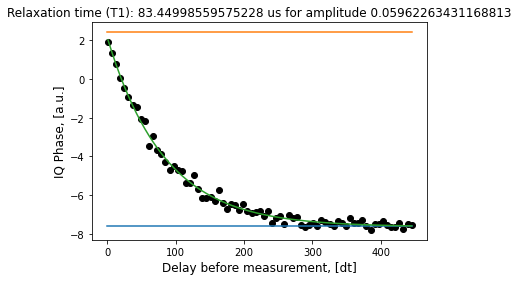

In [40]:
a = 5
num_scheds = len(pulse_info) * len(delay_times_dt)
plt.plot([0,max(times_us)],2*[np.mean(np.angle(t1_results.get_memory(num_scheds)[qb] * scale_factor,deg=True))],label="|0> state") # plot 0 state horizontal line
plt.plot([0,max(times_us)],2*[np.mean(np.angle(t1_results.get_memory(num_scheds+1)[qb] * scale_factor,deg=True))],label="|1> state") # plot 1 state horizontal line

plt.scatter(times_us, t1_values[a], color='black') # plot real part of Rabi values
plt.plot(times_us, all_fits[a])
plt.xlabel('Delay before measurement, [dt]', fontsize=12)
plt.ylabel('IQ Phase, [a.u.]', fontsize=12)
plt.title(f'Relaxation time (T1): {all_T1s[a]} us for amplitude {pulse_info[a][2]}')

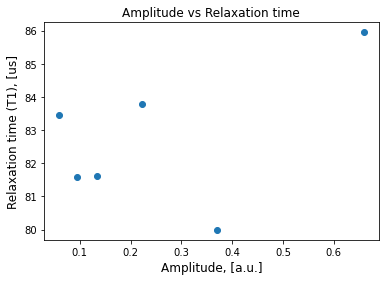

In [16]:
plt.scatter(np.array(pulse_info)[:, 2], all_T1s)
plt.xlabel('Amplitude, [a.u.]', fontsize=12)
plt.ylabel('Relaxation time (T1), [us]', fontsize=12)
plt.title("Amplitude vs Relaxation time")
plt.show()

In [1]:
from qiskit import QuantumCircuit, execute, Aer


In [2]:
from qiskit_textbook.widgets import plot_bloch_vector_spherical
coords = [pi/2,0,1] # [Theta, Phi, Radius]
plot_bloch_vector_spherical(coords) # Bloch Vector with spherical coordinates


ModuleNotFoundError: No module named 'qiskit_textbook'